In [8]:
import json,os
from web3 import Web3
import krakenex
import requests
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from CoinGeckoAPI import CoinGeckoAPI
from PortofolioPlotter import PortfolioPlotter

In [9]:
ADDRESSES_EOA = [
 
]
#print(ADDRESSES_EOA)
ADDRESSES_CONTRACTS = [

] 


In [10]:
def load_array_from_env_var(env_var_name):
    env_var_value = os.getenv(env_var_name)
    if env_var_value is not None:
   
        return [item.strip() for item in env_var_value.split(',')]
    else:
        return None

In [11]:
# loading API for etherscan and coingecko
# both should be added to api.env file 
# in format
# API_ETHERSCAN=""
# API_KEY_COIN_GECKO=""

dotenv_path = 'api.env'
load_dotenv(dotenv_path)

API_ETHERSCAN=os.getenv("API_ETHERSCAN")
API_KEY_COIN_GECKO =os.getenv("API_KEY_COIN_GECKO")
ADDRESSES_EOA=load_array_from_env_var("ADDRESSES_EOA")
ADDRESSES_CONTRACTS=load_array_from_env_var("ADDRESSES_CONTRACTS")
coinGecko=CoinGeckoAPI(API_KEY_COIN_GECKO)

def get_abi():
    with open("abi/" + "erc20" + ".json", 'r') as f:
        json_file = f.read()
    
    result = json.loads(json_file)
    
    return result

def get_token_address(token_name):
    tokens = {
        "GNO": os.getenv("GNO"),
        "GEL": os.getenv("GEL"),
        "COW": os.getenv("COW"),
        "USDC": os.getenv("USDC"),
        "SWISE": os.getenv("SWISE"),
        "WBTC": os.getenv("WBTC")  
        # Add more tokens here
    } 
    return tokens.get(token_name.upper(), "Token not found")


In [12]:
class Portfolio():

    tokens = ["ETH","GNO", "GEL", "COW", "USDC", "SWISE", "WBTC"]


   # RPC_CLIENT = "https://rpc.eth.gateway.fm"
    RPC_CLIENT="https://cloudflare-eth.com/"
    
    def __init__(self, ADDRESSES_EOA, ADDRESSES_CONTRACTS):
        self.ADDRESSES_EOA = ADDRESSES_EOA
        self.ADDRESSES_CONTRACTS = ADDRESSES_CONTRACTS
        
        self.web3 = Web3(Web3.HTTPProvider(Portfolio.RPC_CLIENT))

        self.token_balances={}
        for token in self.tokens:
              self.token_balances[token]=self.get_onchain_balance_total(name=token)
   
        self.token_values={}
        for token in self.tokens:
            self.token_values[token]= self.token_balances[token]*coinGecko.get_token_price(name=token)

        self.portfolio_values = []
        for address in self.ADDRESSES_EOA + self.ADDRESSES_CONTRACTS:
            self.portfolio_values.append(self.get_total_value_single_address(address))
        
        #ne treba
        # self.client = krakenex.API()
        # self.client.load_key(KRAKEN_KEY)
      
    
    @property
    def ADDRESSES(self):
        return self.ADDRESSES_EOA + self.ADDRESSES_CONTRACTS
    
    def get_onchain_eth_balance_single(self, address):
        return self.web3.eth.get_balance(address)/10**18
    

    def get_onchain_balance_single(self, address,name):
        if(name!="ETH"):
            contract=self.web3.eth.contract(get_token_address(name), abi=get_abi())
            return contract.functions.balanceOf(address).call()/10**contract.functions.decimals().call()
        else:
            return self.get_onchain_eth_balance_single(address)
    
    def get_onchain_balance_total(self,name):
        total = 0
        for address in self.ADDRESSES:
            total+=self.get_onchain_balance_single(address,name)
        return total
          
    def get_total_value_single_address(self, address):
        total_price = 0
     
        eth_balance = self.get_onchain_eth_balance_single(address)
        eth_price = coinGecko.get_token_price("ETH")
        eth_value = eth_balance * eth_price
        total_price += eth_value
        
        for token in self.tokens:
            if token != "ETH":
                balance = self.get_onchain_balance_single(address, token)
                price = coinGecko.get_token_price(token)
                price_single_token = price * balance
                total_price += price_single_token
        return total_price
    
    def get_total_value_portfolio(self):
        total = 0
        for address in self.ADDRESSES:
            total += self.get_total_value_single_address(address)
        return total
    
        

In [14]:
p = Portfolio(ADDRESSES_EOA,ADDRESSES_CONTRACTS)

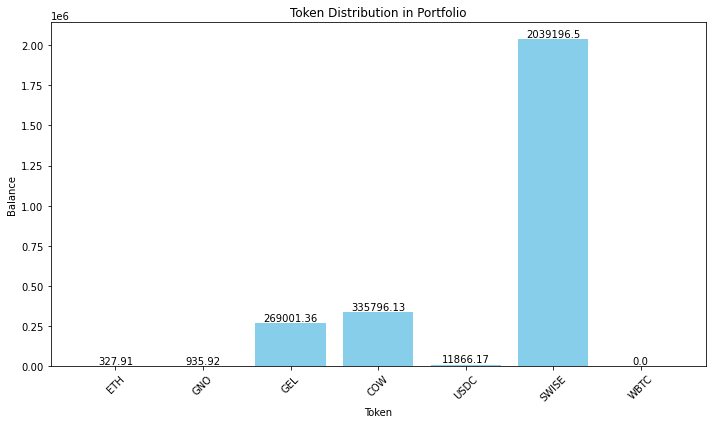

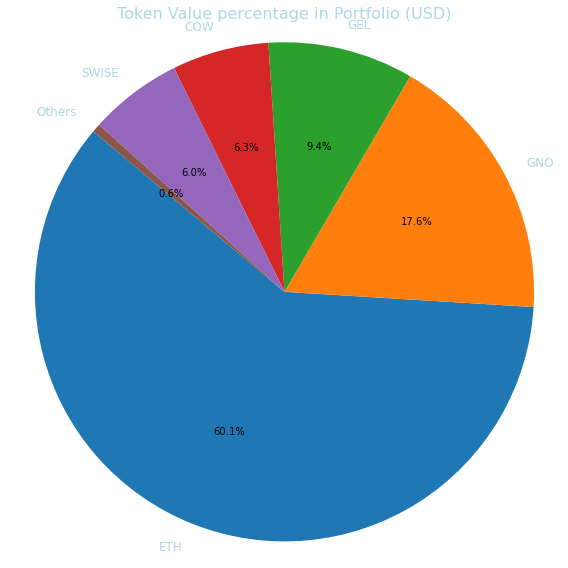

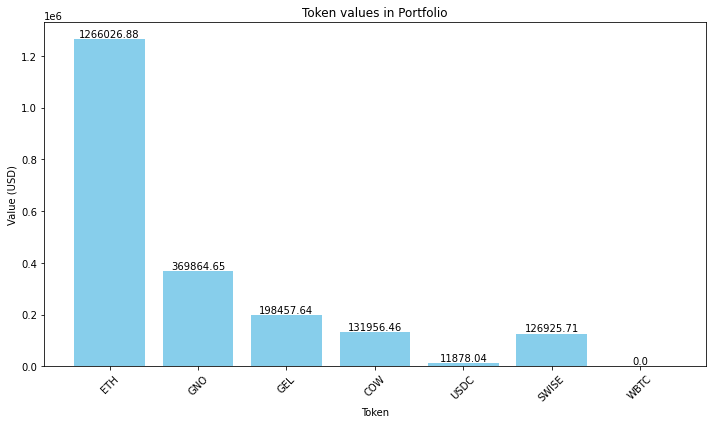

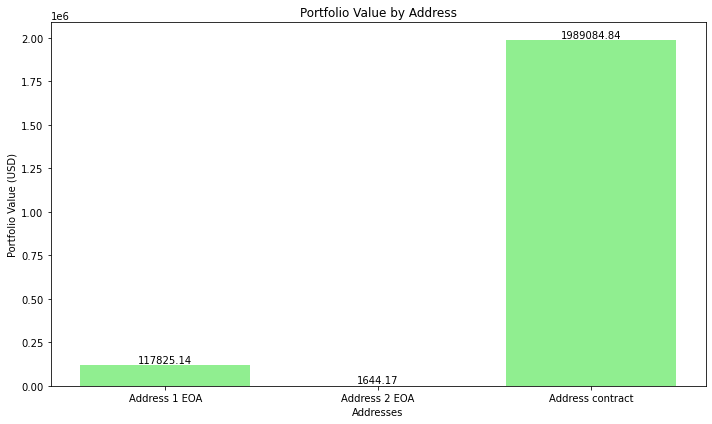

In [ ]:
PortfolioPlotter.plot_token_distribution(p.token_balances)
PortfolioPlotter.plot_token_value_percentage(p.token_values)
PortfolioPlotter.plot_token_values(p.token_values)
PortfolioPlotter.plot_portfolio_value(p.portfolio_values)

